# Cafe Insomnia Project Notebook



## Libraries

In [ ]:
# The notebook uses the following libraries
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import warnings
# hide all python interpreter warnings
warnings.filterwarnings('ignore')

# including library versions for the sake of reproducibility.
print("pandas version: " + pd.__version__)

pandas version: 1.2.3


## Loading in the Data

In [ ]:
# only for google colab use leave commented out
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# connect to database
conn = sqlite3.connect('cafe_insomnia.sqlite')

c = conn.cursor()

# Functions

For the sake of reproducibility some functions have been made, this is also to reduce code clutter and repeated code.

In [ ]:
# Generate generic qq plot
def plot_qq(residual):
  fig = sm.qqplot(residual, line='45')
  plt.title('Normal Q-Q Plot')

# Generate generic residuals scatter plot
def plot_residuals(y_pred,residual):
  plt.scatter(y_pred, residual)
  plt.xlabel('y_pred')
  plt.ylabel('Residuals ')
  plt.title('Residual Plot')

# Data Preperation
Data Selection, Cleaning and Formatting

In [ ]:
# Merging the variables of interest into a single table - also cleans the dataset due to the use of INNER JOIN
df = pd.read_sql('''SELECT t.*, s.name as building_name, s.dist_to_cafe, d.name as drink_name, d.unit_price FROM ci_transaction t
                                  inner JOIN study_area s
                                  ON t.study_area_id = s.id
                                  inner JOIN drink d
                                  ON t.drink_id = d.id
                                  ORDER BY t.id ASC''',conn)

df

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id,building_name,dist_to_cafe,drink_name,unit_price
0,0,2019-07-22,0,Mon,0,5,1,No,3,Abercrombie (H70),700,Flat White (L),4.9
1,1,2019-07-22,0,Mon,0,5,1,No,1,Law Library (F10),84,Flat White (L),4.9
2,2,2019-07-22,0,Mon,0,2,1,No,5,Carslaw (F07),150,Macchiato,3.8
3,3,2019-07-22,0,Mon,0,2,1,No,6,Peter Nicol Russell (PNR),950,Macchiato,3.8
4,4,2019-07-22,0,Mon,0,5,1,No,5,Carslaw (F07),150,Flat White (L),4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27166,27709,2019-12-22,153,Sun,5,14,2,No,3,Abercrombie (H70),700,Mocha (S),4.5
27167,27710,2019-12-22,153,Sun,5,6,1,No,3,Abercrombie (H70),700,Flat White (S),4.0
27168,27711,2019-12-22,153,Sun,5,12,1,No,0,Fisher Library (F03),70,Chai Latte (S),3.6
27169,27712,2019-12-22,153,Sun,5,9,1,No,4,Brennan MacCallum (A18),350,Cappuccino (L),4.9


In [ ]:
# SQL query to calculate hourly sales
multi_df = pd.read_sql('''SELECT quantity * unit_price as singletime_sales from
                                  (SELECT t.*, s.name as building_name, s.dist_to_cafe, d.name as drink_name, d.unit_price
                                  FROM ci_transaction t
                                  inner JOIN study_area s
                                  ON t.study_area_id = s.id
                                  inner JOIN drink d
                                  ON t.drink_id = d.id
                                  ORDER BY t.id ASC) ''',conn)

df['hourly_sales'] = multi_df

# daily sales hour - simply a combination of days after open and hours after open into 1 column
df['daily_sales_hour'] = df['days_after_open'].astype(str) + '(' + df['hours_after_open'].astype(str) +')'

# Code from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
# drop unwanted columns
df = df.drop(['date','id','drink_id','study_area_id'],axis=1)
df

,days_after_open,day_of_week,hours_after_open,quantity,raining,building_name,dist_to_cafe,drink_name,unit_price,hourly_sales,daily_sales_hour
0,0,Mon,0,1,No,Abercrombie (H70),700,Flat White (L),4.9,4.9,0(0)
1,0,Mon,0,1,No,Law Library (F10),84,Flat White (L),4.9,4.9,0(0)
2,0,Mon,0,1,No,Carslaw (F07),150,Macchiato,3.8,3.8,0(0)
3,0,Mon,0,1,No,Peter Nicol Russell (PNR),950,Macchiato,3.8,3.8,0(0)
4,0,Mon,0,1,No,Carslaw (F07),150,Flat White (L),4.9,4.9,0(0)
...,...,...,...,...,...,...,...,...,...,...,...
27166,153,Sun,5,2,No,Abercrombie (H70),700,Mocha (S),4.5,9.0,153(5)
27167,153,Sun,5,1,No,Abercrombie (H70),700,Flat White (S),4.0,4.0,153(5)
27168,153,Sun,5,1,No,Fisher Library (F03),70,Chai Latte (S),3.6,3.6,153(5)
27169,153,Sun,5,1,No,Brennan MacCallum (A18),350,Cappuccino (L),4.9,4.9,153(5)


## **Q1: What affects Café Insomnia’s hourly sales (in AUD)?**



### Part 1: Identifying if number of days since hte pop-up store opened affects hourly sales.

In [ ]:
# Create a groupby dataframe to compare days and hours after open to the total hourly_sales
hourly_sales_days = df.groupby(['days_after_open','daily_sales_hour']).sum()['hourly_sales'].reset_index()

# Create a groupby dataframe to compare days after open with average hourly sales
hourly_sales_d = hourly_sales_days.groupby(['days_after_open']).mean().reset_index()

hourly_sales_d

,days_after_open,hourly_sales
0,0,46.683333
1,1,58.316667
2,2,58.483333
3,3,52.516667
4,4,31.266667
...,...,...
149,149,352.516667
150,150,349.950000
151,151,292.516667
152,152,308.733333


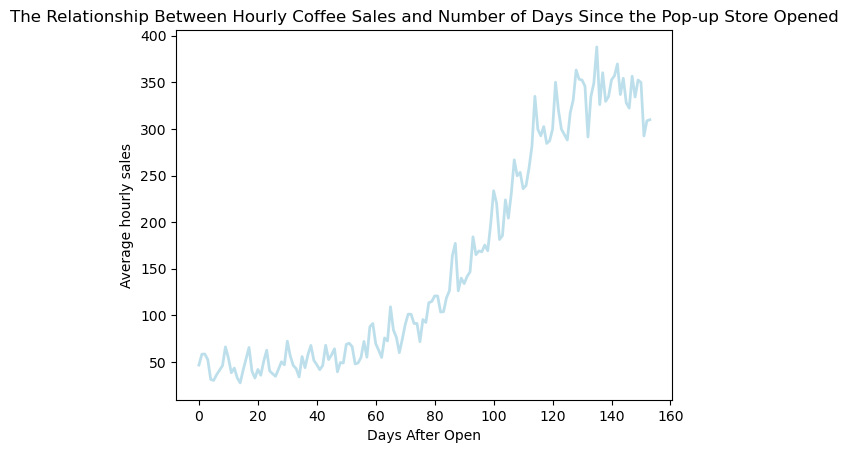

In [ ]:
# Plot a line graph of days_after_open vs hourly sales
plt.plot(hourly_sales_d['hourly_sales'],color = 'lightblue',linewidth=2, alpha = 0.8)

# Labelling the graph
plt.xlabel('Days After Open')
plt.ylabel('Average hourly sales')
plt.title('The Relationship Between Hourly Coffee Sales and Number of Days Since the Pop-up Store Opened')

plt.savefig('plot')

### Part 2: Identifying if seasonal factors (day-of-the-week) affects hourly sales.

In [ ]:
# Grouping day of the week by the total hourly sales
hourly_sales_dw = df.groupby(['day_of_week']).sum()['hourly_sales'].reset_index()

# Grouping to find the average hourly sales for each day of the week.
hourly_sales_dw_gb= hourly_sales_dw.groupby(['day_of_week']).mean()

# Manually sort the days of the week from Mon to Sun
hourly_sales_dw_gb = hourly_sales_dw_gb.reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

hourly_sales_dw_gb

,hourly_sales
day_of_week,
Mon,19337.5
Tue,20527.7
Wed,23484.7
Thu,21880.4
Fri,20383.2
Sat,19533.1
Sun,19593.8


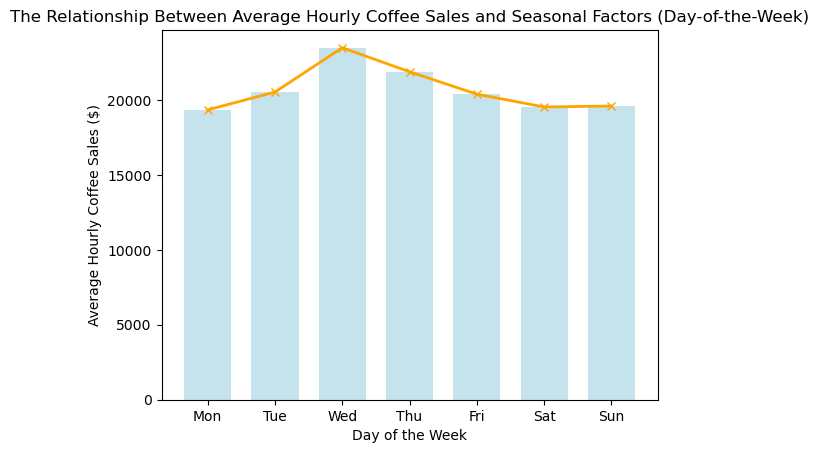

In [ ]:
# Plot a bar chart with an accompanying line plot
plt.bar(hourly_sales_dw_gb. index, height = hourly_sales_dw_gb['hourly_sales'],color = 'lightblue',alpha = 0.7, align = 'center',width = 0.7)
plt.plot(hourly_sales_dw_gb,color = 'orange', marker = 'x', linewidth = 2)

# Labelling the graph
plt.xlabel('Day of the Week')
plt.ylabel('Average Hourly Coffee Sales ($)')
plt.title('The Relationship Between Average Hourly Coffee Sales and Seasonal Factors (Day-of-the-Week)')

plt.show()

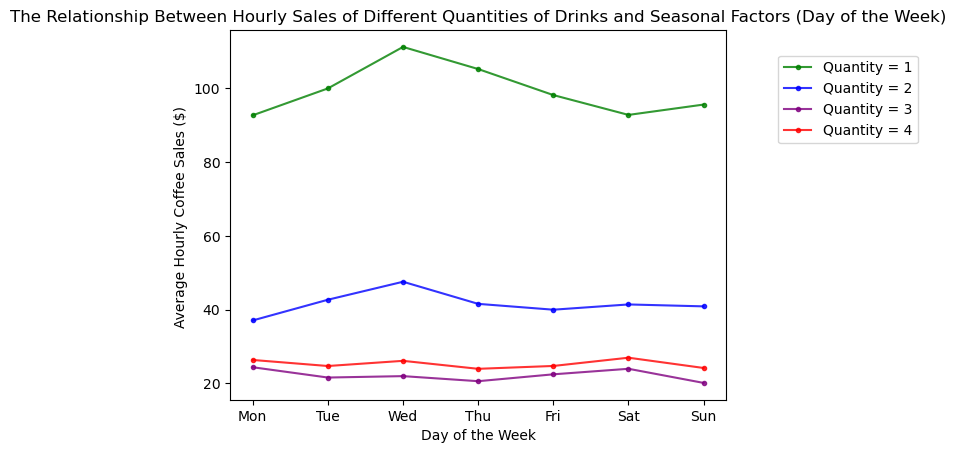

In [ ]:
# Code from https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html

# Get unique quantities in the DataFrame
quantities = df['quantity'].unique()

# Define colors and labels for the plot
colors = ['green', 'blue', 'purple', 'red']
labels = ['Quantity = 1', 'Quantity = 2', 'Quantity = 3', 'Quantity = 4']

# Dictionary to store hourly sales grouped by quantity
hourly_sales_gb = {}

# Iterate through each quantity
for quantity, color, label in zip(quantities, colors, labels):
    # Create a DataFrame for the current quantity
    q = df.query(f'quantity == {quantity}')

    # Group by day of the week and hourly sales, then calculate the mean
    hourly_sales = q.groupby(['day_of_week', 'daily_sales_hour']).sum()['hourly_sales'].reset_index()
    hourly_sales_gb[quantity] = hourly_sales.groupby('day_of_week').mean().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Plot the data for the current quantity
    plt.plot(hourly_sales_gb[quantity], color=color, marker='.', linewidth=1.5, alpha=0.8, label=label)

# Labelling the graph
plt.xlabel('Day of the Week')
plt.ylabel('Average Hourly Coffee Sales ($)')
plt.title('The Relationship Between Hourly Sales of Different Quantities of Drinks and Seasonal Factors (Day of the Week)')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.95))
plt.show()

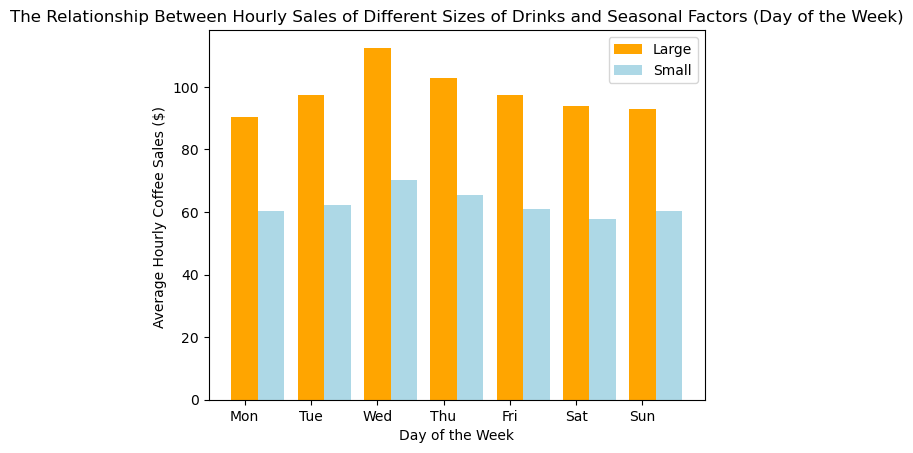

In [ ]:
# Code from https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html

# Filter for large and small drinks
large = df[df['drink_name'].str.contains('L')]
small = df[df['drink_name'].str.contains('S')]

# Group by day of the week and hourly sales, then calculate the mean
hourly_sales_L_gb = large.groupby(['day_of_week', 'daily_sales_hour'])['hourly_sales'].sum().unstack('day_of_week').mean()
hourly_sales_S_gb = small.groupby(['day_of_week', 'daily_sales_hour'])['hourly_sales'].sum().unstack('day_of_week').mean()

# Configuring the graph label positions
xpos = np.arange(7) + 1  # 1 to 7
bar_width = 0.4
adjusted_xpos = xpos + bar_width

plt.bar(xpos, hourly_sales_L_gb, label='Large', width=bar_width, color='orange', alpha=1, align='center')
plt.bar(adjusted_xpos, hourly_sales_S_gb, label='Small', width=bar_width, color='lightblue', alpha=1, align='center')

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(xpos + bar_width / 2, labels)  # Adjust xticks

# Labelling the graph
plt.xlabel('Day of the Week')
plt.ylabel('Average Hourly Coffee Sales ($)')
plt.title('The Relationship Between Hourly Sales of Different Sizes of Drinks and Seasonal Factors (Day of the Week)')
plt.legend()
plt.show()

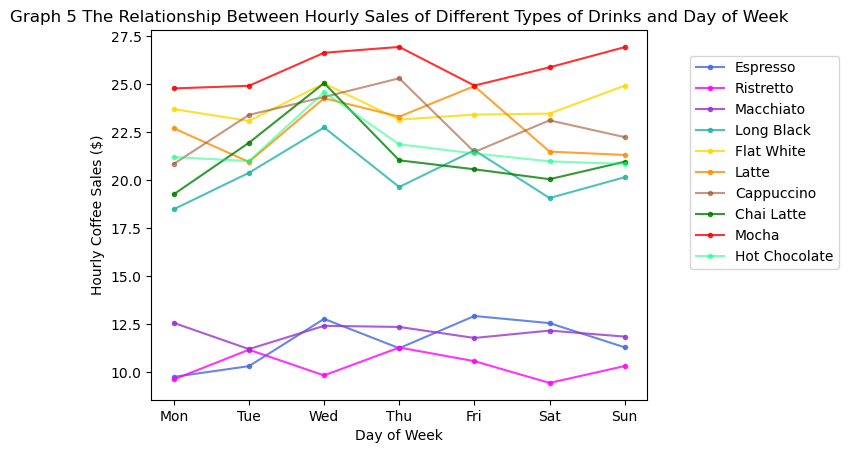

In [ ]:
# Define the different types of drinks and their respective colors
drink_types = {
    'Espresso': 'royalblue',
    'Ristretto': 'magenta',
    'Macchiato': 'darkorchid',
    'Long Black': 'lightseagreen',
    'Flat White': 'gold',
    'Latte': 'darkorange',
    'Cappuccino': 'sienna',
    'Chai Latte': 'green',
    'Mocha': 'r',
    'Hot Chocolate': 'springgreen'
}

# Create a dictionary to store hourly sales and group by day of the week
hourly_sales_gb = {}

for drink_name, color in drink_types.items():
    # Filter the DataFrame for the current drink
    drink_df = df[df['drink_name'].str.contains(drink_name)]

    # Group by day of the week and hourly sales, then calculate the mean
    hourly_sales = drink_df.groupby(['day_of_week', 'daily_sales_hour'])['hourly_sales'].sum().unstack('day_of_week').mean()

    # Store the hourly sales in the dictionary
    hourly_sales_gb[drink_name] = hourly_sales

    # Plot the data for the current drink
    plt.plot(hourly_sales_gb[drink_name], color=color, marker='.', linewidth=1.5, alpha=0.8, label=drink_name)

# Configuring the graph label positions
xpos = np.arange(7) + 1  # 1 to 7
bar_width = 0.4
adjusted_xpos = xpos + bar_width

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(xpos + bar_width / 2, labels)  # Adjust xticks

# Labelling the graph
plt.xlabel('Day of the Week')
plt.ylabel('Hourly Coffee Sales ($)')
plt.title('The Relationship Between Hourly Sales of Different Types of Drinks and Day of the Week')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.95))
plt.show()

In [ ]:
# Group the total average hourly sales by the hours after open
hourly_sales_hd = df.groupby(['hours_after_open','daily_sales_hour']).sum()['hourly_sales'].reset_index()
hourly_sales_hd_gb = hourly_sales_hd.groupby('hours_after_open').mean()

hourly_sales_hd_gb

,hourly_sales
hours_after_open,
0,165.035714
1,171.804545
2,165.605844
3,155.164935
4,147.015584
5,135.246104


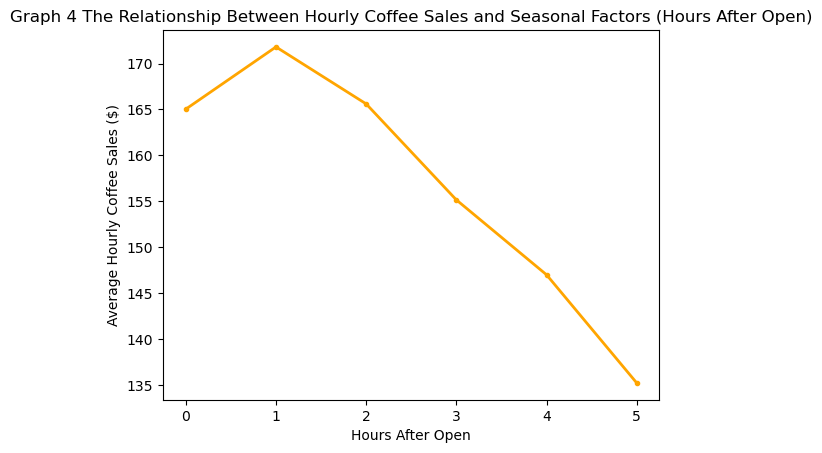

In [ ]:
# Plot a line graph to visualise the trends
plt.plot(hourly_sales_hd_gb,color = 'orange', marker = '.',linewidth = 2)

# Label the graph
plt.xlabel('Hours After Open')
plt.ylabel('Average Hourly Coffee Sales ($)')
plt.title('Graph 4 The Relationship Between Hourly Coffee Sales and Seasonal Factors (Hours After Open)')

plt.show()

### Part 3: Identifying if the location on campus that the customer is studying at and whether it is raining affects the hourly sales.

In [ ]:
# Finding the total average hourly sales for each location on campus
hourly_sales_bn = df.groupby(['building_name','dist_to_cafe','daily_sales_hour']).sum()['hourly_sales'].reset_index()
hourly_sales_bn_gb = hourly_sales_bn.groupby(['building_name','dist_to_cafe']).mean().sort_values('dist_to_cafe').reset_index()

hourly_sales_bn_gb

,building_name,dist_to_cafe,hourly_sales
0,Fisher Library (F03),70,45.434498
1,Law Library (F10),84,41.088751
2,Carslaw (F07),150,30.721951
3,Brennan MacCallum (A18),350,19.982386
4,The Quarter (A16),400,19.519238
5,Abercrombie (H70),700,20.631391
6,Peter Nicol Russell (PNR),950,20.889122


In [ ]:
# Finding the total average hourly sales for when it is raining and when it is not
hourly_sales_rn = df.groupby(['raining','daily_sales_hour']).sum()['hourly_sales'].reset_index()

hourly_sales_rn_gb = hourly_sales_rn.groupby(['raining']).mean().reset_index()

hourly_sales_rn_gb

,raining,hourly_sales
0,No,168.622080
1,Yes,131.610702


In [ ]:
# Grouping the total average hourly sales for when it is raining based on the days and hours after open (daily_sales_hour).
hourly_sales_rn = df.groupby(['raining','days_after_open','daily_sales_hour']).sum()['hourly_sales'].reset_index().drop(['days_after_open'],axis=1)
hourly_sales_rn_gb=hourly_sales_rn.groupby(['raining']).mean().reset_index()

hourly_sales_rn.reset_index()

,index,raining,daily_sales_hour,hourly_sales
0,0,No,0(0),49.0
1,1,No,0(1),83.6
2,2,No,0(3),50.6
3,3,No,0(5),43.5
4,4,No,1(0),65.8
...,...,...,...,...
919,919,Yes,151(4),288.4
920,920,Yes,151(5),250.7
921,921,Yes,152(4),232.2
922,922,Yes,152(5),233.2


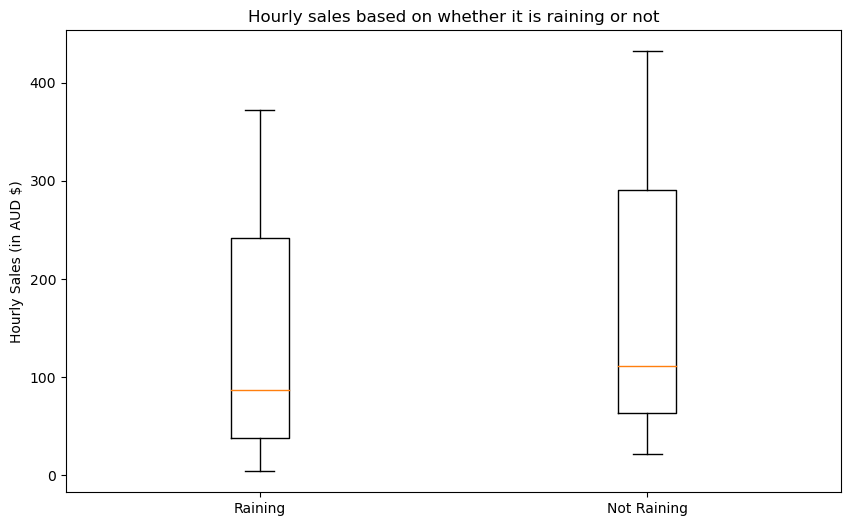

In [ ]:
# Code obtained from: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html

# filter into 2 separate dataframes for when it is raining and when it is not raining
yes_rain = hourly_sales_rn.query("raining == 'Yes'")
no_rain = hourly_sales_rn.query("raining == 'No'")

# plot the boxplot
fig,ax = plt.subplots(figsize=(10,6))

# store the 2 filitered data frames into a list
df1= [yes_rain['hourly_sales'],no_rain['hourly_sales']]
ax.boxplot(df1)
plt.ylabel('Hourly Sales (in AUD $)')
plt.xticks([1, 2], ["Raining", "Not Raining"])
plt.title('Hourly sales based on whether it is raining or not')
plt.show()

In [ ]:
# Splitting the main dataframe into 2 separate frames based on whether it is raining or not
rain_yes = df.loc[df['raining'] == 'Yes']
rain_no = df.loc[df['raining'] == 'No']

In [ ]:
#-----------------------Calculate the total average hourly sales based on distance to cafe-------------------------
hourly_sales_no_raining = rain_no.groupby(['dist_to_cafe','daily_sales_hour']).sum()['hourly_sales'].reset_index()
hourly_sales_yes_raining = rain_yes.groupby(['dist_to_cafe','daily_sales_hour']).sum()['hourly_sales'].reset_index()

hourly_sales_no_raining_gb = hourly_sales_no_raining.groupby(['dist_to_cafe']).mean().reset_index()
hourly_sales_yes_raining_gb = hourly_sales_yes_raining.groupby(['dist_to_cafe']).mean().reset_index()
#-----------------------Calculate the total average hourly sales based on distance to cafe-------------------------

# outputting the dataframe to see if it is correct
hourly_sales_yes_raining_gb

,dist_to_cafe,hourly_sales
0,70,67.046575
1,84,54.083103
2,150,17.782174


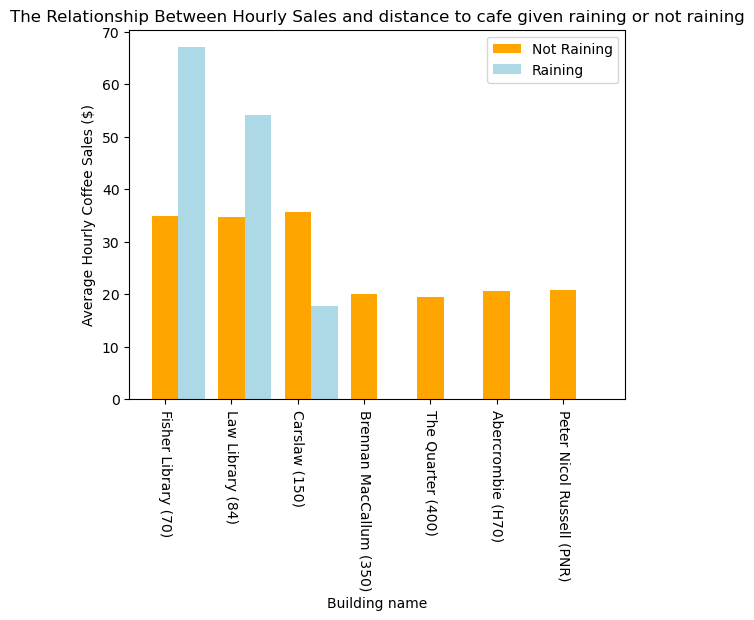

In [ ]:
#---------Configuring graph labelling positions-------------------------
hourly_sales_yes_raining_gb.loc[3] =[350,0]
hourly_sales_yes_raining_gb.loc[4] =[400,0]
hourly_sales_yes_raining_gb.loc[5] =[700,0]
hourly_sales_yes_raining_gb.loc[6] =[950,0]

xpos = [1,2,3,4,5,6,7]
h1 = hourly_sales_no_raining_gb['hourly_sales']
h2 = hourly_sales_yes_raining_gb['hourly_sales']

adjusted_xpos = np.add(xpos, 0.4)
#---------Configuring graph labelling positions-------------------------

# Plot the graph
plt.bar(xpos, h1,label = 'Not Raining',width = 0.4,color = 'orange', alpha = 1, align = 'center')
plt.bar(adjusted_xpos, h2, label = 'Raining',width =0.4, color = 'lightblue', alpha = 1,align = 'center')

# Labelling the graph
labels = ['Fisher Library (70)','Law Library (84)','Carslaw (150)','Brennan MacCallum (350)','The Quarter (400)','Abercrombie (H70)','Peter Nicol Russell (PNR)']
plt.xticks(xpos, labels)
plt.xlabel('Building name')
plt.xticks(rotation=270)
plt.ylabel('Average Hourly Coffee Sales ($)')
plt.title('The Relationship Between Hourly Sales and distance to cafe given raining or not raining')
plt.legend()

plt.show()

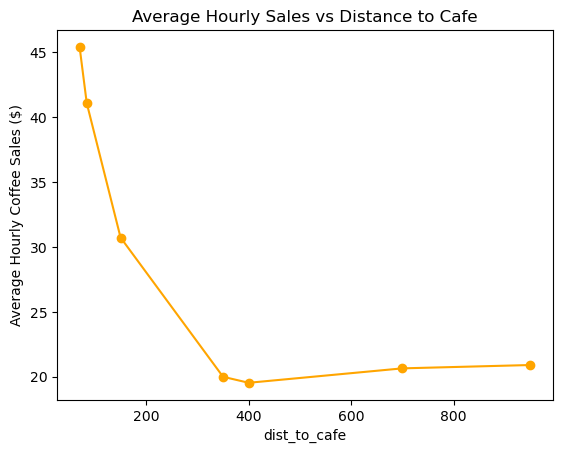

In [ ]:
# Plot the graph
plt.plot(hourly_sales_bn_gb['dist_to_cafe'],hourly_sales_bn_gb['hourly_sales'],  '-o',color = 'orange')

# Label the graph
plt.xlabel('dist_to_cafe')
plt.ylabel('Average Hourly Coffee Sales ($)')
plt.title('Average Hourly Sales vs Distance to Cafe')

plt.show()

## Q2: Can a model be built to predict hourly sales (in AUD)?



### Dummy Variables

In [ ]:
# Converting categorical variables into dummy/indicator variables
data_daily_sales_hour = df['daily_sales_hour']
df = df.drop(['daily_sales_hour'],axis=1)

data_dm = pd.get_dummies(df,drop_first = True)
data_dm['daily_sales_hour']=data_daily_sales_hour
data_dm

,days_after_open,hours_after_open,quantity,dist_to_cafe,unit_price,hourly_sales,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,...,drink_name_Hot Chocolate (S),drink_name_Latte (L),drink_name_Latte (S),drink_name_Long Black (L),drink_name_Long Black (S),drink_name_Macchiato,drink_name_Mocha (L),drink_name_Mocha (S),drink_name_Ristretto,daily_sales_hour
0,0,0,1,700,4.9,4.9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0(0)
1,0,0,1,84,4.9,4.9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0(0)
2,0,0,1,150,3.8,3.8,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0(0)
3,0,0,1,950,3.8,3.8,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0(0)
4,0,0,1,150,4.9,4.9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0(0)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27166,153,5,2,700,4.5,9.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,153(5)
27167,153,5,1,700,4.0,4.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,153(5)
27168,153,5,1,70,3.6,3.6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,153(5)
27169,153,5,1,350,4.9,4.9,0,0,1,0,...,0,0,0,0,0,0,0,0,0,153(5)


In [ ]:
# Finding the total sales grouped by 'days after open' and 'daily_sales_hour' using a df with dummy variables.
data_dm_hs = data_dm.groupby(['days_after_open','daily_sales_hour']).sum()['hourly_sales'].reset_index()
data_dm_hs = data_dm_hs.drop(['days_after_open'],axis=1)
data_dm_hs

,daily_sales_hour,hourly_sales
0,0(0),49.0
1,0(1),83.6
2,0(2),37.3
3,0(3),50.6
4,0(4),16.1
...,...,...
919,153(1),364.7
920,153(2),326.1
921,153(3),266.0
922,153(4),320.7


In [ ]:
# Finding the total average sales grouped by 'days after open' and 'daily_sales hour' using a df with dummy variables.
data_dm_a = data_dm.groupby(['days_after_open','daily_sales_hour']).mean().drop(['hourly_sales'],axis=1).reset_index()
data_dm_a

,days_after_open,daily_sales_hour,hours_after_open,quantity,dist_to_cafe,unit_price,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,...,drink_name_Hot Chocolate (L),drink_name_Hot Chocolate (S),drink_name_Latte (L),drink_name_Latte (S),drink_name_Long Black (L),drink_name_Long Black (S),drink_name_Macchiato,drink_name_Mocha (L),drink_name_Mocha (S),drink_name_Ristretto
0,0,0(0),0.0,1.000000,264.363636,4.454545,1.0,0.0,0.0,0.0,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.181818,0.000000,0.000000,0.000000
1,0,0(1),1.0,1.615385,246.769231,4.061538,1.0,0.0,0.0,0.0,...,0.076923,0.000000,0.000000,0.076923,0.000000,0.076923,0.153846,0.000000,0.000000,0.000000
2,0,0(2),2.0,1.333333,77.000000,4.650000,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.333333,0.000000,0.166667
3,0,0(3),3.0,1.500000,471.000000,4.100000,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.125000,0.125000,0.000000,0.125000,0.125000,0.000000,0.000000
4,0,0(4),4.0,1.333333,101.333333,4.100000,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,153,153(1),1.0,1.338710,274.741935,4.433871,0.0,0.0,1.0,0.0,...,0.064516,0.048387,0.096774,0.064516,0.064516,0.016129,0.064516,0.096774,0.048387,0.032258
920,153,153(2),2.0,1.262295,285.180328,4.208197,0.0,0.0,1.0,0.0,...,0.098361,0.049180,0.016393,0.016393,0.065574,0.098361,0.081967,0.032787,0.049180,0.016393
921,153,153(3),3.0,1.260000,81.440000,4.254000,0.0,0.0,1.0,0.0,...,0.120000,0.060000,0.080000,0.040000,0.020000,0.040000,0.060000,0.020000,0.060000,0.120000
922,153,153(4),4.0,1.344828,317.206897,4.181034,0.0,0.0,1.0,0.0,...,0.068966,0.068966,0.086207,0.086207,0.000000,0.086207,0.086207,0.017241,0.068966,0.034483


In [ ]:
# Merging the previous 2 dataframes
data_before_corr = pd.merge(data_dm_hs,data_dm_a,left_on='daily_sales_hour',right_on ='daily_sales_hour',how='inner',indicator=False)
data_before_corr

,daily_sales_hour,hourly_sales,days_after_open,hours_after_open,quantity,dist_to_cafe,unit_price,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,...,drink_name_Hot Chocolate (L),drink_name_Hot Chocolate (S),drink_name_Latte (L),drink_name_Latte (S),drink_name_Long Black (L),drink_name_Long Black (S),drink_name_Macchiato,drink_name_Mocha (L),drink_name_Mocha (S),drink_name_Ristretto
0,0(0),49.0,0,0.0,1.000000,264.363636,4.454545,1.0,0.0,0.0,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.181818,0.000000,0.000000,0.000000
1,0(1),83.6,0,1.0,1.615385,246.769231,4.061538,1.0,0.0,0.0,...,0.076923,0.000000,0.000000,0.076923,0.000000,0.076923,0.153846,0.000000,0.000000,0.000000
2,0(2),37.3,0,2.0,1.333333,77.000000,4.650000,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.333333,0.000000,0.166667
3,0(3),50.6,0,3.0,1.500000,471.000000,4.100000,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.125000,0.125000,0.000000,0.125000,0.125000,0.000000,0.000000
4,0(4),16.1,0,4.0,1.333333,101.333333,4.100000,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,153(1),364.7,153,1.0,1.338710,274.741935,4.433871,0.0,0.0,1.0,...,0.064516,0.048387,0.096774,0.064516,0.064516,0.016129,0.064516,0.096774,0.048387,0.032258
920,153(2),326.1,153,2.0,1.262295,285.180328,4.208197,0.0,0.0,1.0,...,0.098361,0.049180,0.016393,0.016393,0.065574,0.098361,0.081967,0.032787,0.049180,0.016393
921,153(3),266.0,153,3.0,1.260000,81.440000,4.254000,0.0,0.0,1.0,...,0.120000,0.060000,0.080000,0.040000,0.020000,0.040000,0.060000,0.020000,0.060000,0.120000
922,153(4),320.7,153,4.0,1.344828,317.206897,4.181034,0.0,0.0,1.0,...,0.068966,0.068966,0.086207,0.086207,0.000000,0.086207,0.086207,0.017241,0.068966,0.034483


In [ ]:
# Calculating the Correlation between variables
data_before_corr.corr()

,hourly_sales,days_after_open,hours_after_open,quantity,dist_to_cafe,unit_price,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,...,drink_name_Hot Chocolate (L),drink_name_Hot Chocolate (S),drink_name_Latte (L),drink_name_Latte (S),drink_name_Long Black (L),drink_name_Long Black (S),drink_name_Macchiato,drink_name_Mocha (L),drink_name_Mocha (S),drink_name_Ristretto
hourly_sales,1.000000,9.100491e-01,-9.503652e-02,0.074477,0.121972,-0.015004,-3.452317e-02,-0.029483,-2.791849e-02,3.100566e-02,...,-0.070758,0.021982,-0.033010,-0.021696,-0.053799,0.039476,-0.043161,0.034955,0.030357,-0.013416
days_after_open,0.910049,1.000000e+00,1.648953e-16,0.006974,-0.007059,-0.037453,-2.755020e-02,0.018367,2.755020e-02,-1.248191e-16,...,-0.083415,0.012641,-0.044995,-0.011944,-0.051246,0.043056,-0.042142,0.026331,0.051958,0.002057
hours_after_open,-0.095037,1.648953e-16,1.000000e+00,0.000898,0.011554,-0.035265,8.042244e-18,0.000000,1.125914e-17,1.005281e-19,...,-0.012849,0.022870,0.029748,-0.043610,0.033782,-0.005619,0.065466,-0.029891,-0.039734,0.071510
quantity,0.074477,6.973977e-03,8.978236e-04,1.000000,0.042385,-0.009763,1.688711e-02,-0.026056,2.248382e-02,2.923715e-02,...,0.040984,-0.002648,-0.054469,-0.010977,-0.065504,0.023735,-0.018307,-0.081371,-0.012760,-0.016161
dist_to_cafe,0.121972,-7.058730e-03,1.155375e-02,0.042385,1.000000,0.000404,2.641787e-02,0.019105,-4.124919e-02,-7.366306e-02,...,-0.010303,0.039047,0.003576,0.019627,-0.009918,0.008651,0.017882,0.019105,0.012819,-0.049140
unit_price,-0.015004,-3.745293e-02,-3.526517e-02,-0.009763,0.000404,1.000000,4.332163e-02,-0.058236,1.266296e-02,-6.030670e-02,...,0.222870,-0.115056,0.355433,-0.060845,-0.197012,-0.163764,-0.147917,0.484850,0.081451,-0.442676
day_of_week_Mon,-0.034523,-2.755020e-02,8.042244e-18,0.016887,0.026418,0.043322,1.000000e+00,-0.166667,-1.666667e-01,-1.666667e-01,...,-0.007283,-0.062525,0.059497,-0.010038,0.003128,-0.003781,0.067239,0.005742,0.073860,-0.042250
day_of_week_Sat,-0.029483,1.836680e-02,0.000000e+00,-0.026056,0.019105,-0.058236,-1.666667e-01,1.000000,-1.666667e-01,-1.666667e-01,...,-0.030191,0.010076,-0.020040,0.036333,-0.010043,0.032509,-0.040099,-0.063723,-0.013264,0.017524
day_of_week_Sun,-0.027918,2.755020e-02,1.125914e-17,0.022484,-0.041249,0.012663,-1.666667e-01,-0.166667,1.000000e+00,-1.666667e-01,...,0.030167,-0.001409,-0.035307,-0.022719,0.031672,-0.030699,-0.037671,0.035580,-0.023796,0.040970
day_of_week_Thu,0.031006,-1.248191e-16,1.005281e-19,0.029237,-0.073663,-0.060307,-1.666667e-01,-0.166667,-1.666667e-01,1.000000e+00,...,-0.065494,0.011493,0.017815,-0.015442,0.017450,0.060243,0.017572,-0.016390,-0.035155,-0.000403


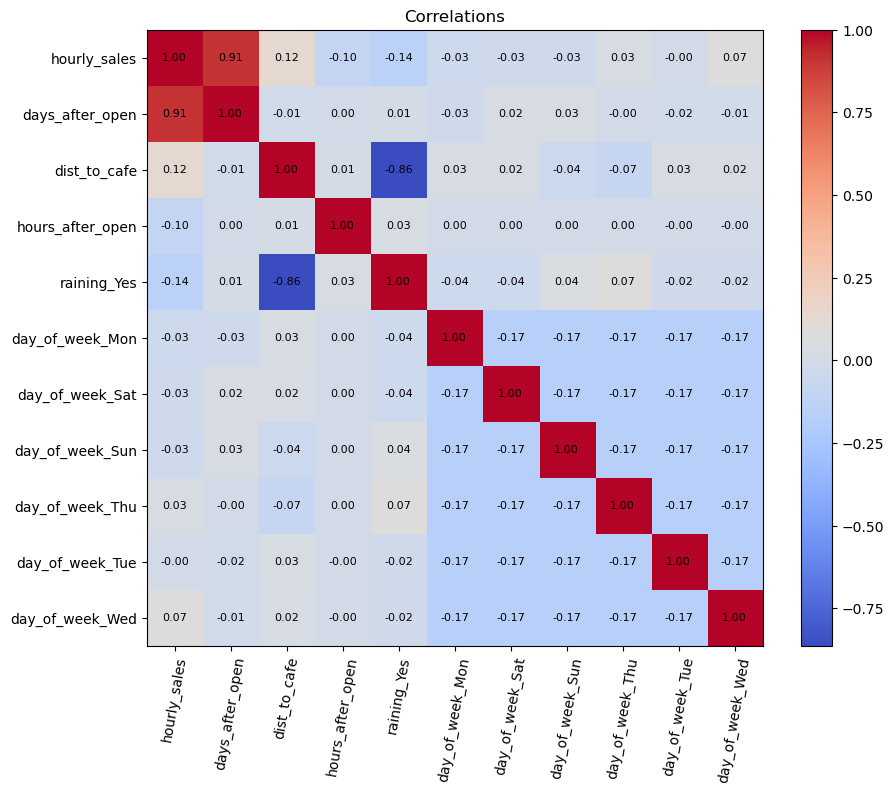

In [ ]:
corr = data_before_corr[['hourly_sales','days_after_open','dist_to_cafe','hours_after_open','raining_Yes', 'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun',
       'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed']].corr()
n_var = len(corr) # Number of variables
fig,ax = plt.subplots(figsize=(10,8))
# Plot the heatmap
plt.imshow(corr, cmap = 'coolwarm')

plt.xticks(range(n_var), corr.columns,rotation=80)
plt.yticks(range(n_var), corr.columns)

for i in range(n_var):
    for j in range(n_var):
        #              format to 2 decimal places  ,  horizonta/vertical align center
        plt.text(i, j, '{:.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="k", fontsize = 8)

plt.colorbar()

plt.title('Correlations')
plt.savefig('correlation.png')

In [ ]:
# Printing out the corr matrix
data_before_corr.corr()['hourly_sales'].reset_index().sort_values(by = ['hourly_sales'],ascending = False)

,index,hourly_sales
0,hourly_sales,1.000000
1,days_after_open,0.910049
4,dist_to_cafe,0.121972
18,building_name_The Quarter (A16),0.110821
13,building_name_Brennan MacCallum (A18),0.095398
22,drink_name_Espresso,0.087375
3,quantity,0.074477
11,day_of_week_Wed,0.072347
17,building_name_Peter Nicol Russell (PNR),0.069188
14,building_name_Carslaw (F07),0.067044


### Hypothesis Test

In [ ]:
X = sm.add_constant(data_before_corr['quantity'])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.143
Date:                Sun, 06 Jun 2021   Prob (F-statistic):             0.0236
Time:                        11:19:03   Log-Likelihood:                -5732.3
No. Observations:                 924   AIC:                         1.147e+04
Df Residuals:                     922   BIC:                         1.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.9933     29.655      3.035      0.0

In [ ]:
X = sm.add_constant(data_before_corr[['hours_after_open']])

y=data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.403
Date:                Sun, 06 Jun 2021   Prob (F-statistic):            0.00383
Time:                        11:19:03   Log-Likelihood:                -5730.7
No. Observations:                 924   AIC:                         1.147e+04
Df Residuals:                     922   BIC:                         1.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              173.3423      6.975  

In [ ]:
X = sm.add_constant(data_before_corr['days_after_open'])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     4444.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:19:03   Log-Likelihood:                -4921.1
No. Observations:                 924   AIC:                             9846.
Df Residuals:                     922   BIC:                             9856.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -31.3090      3.261     

In [ ]:
X = sm.add_constant(data_before_corr['dist_to_cafe'])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     13.92
Date:                Sun, 06 Jun 2021   Prob (F-statistic):           0.000202
Time:                        11:19:03   Log-Likelihood:                -5728.0
No. Observations:                 924   AIC:                         1.146e+04
Df Residuals:                     922   BIC:                         1.147e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          128.0770      8.603     14.888   

In [ ]:
X = sm.add_constant(data_before_corr[['building_name_Fisher Library (F03)','building_name_Law Library (F10)', 'building_name_Carslaw (F07)','building_name_Brennan MacCallum (A18)','building_name_The Quarter (A16)','building_name_Peter Nicol Russell (PNR)']])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.340
Date:                Sun, 06 Jun 2021   Prob (F-statistic):            0.00293
Time:                        11:19:03   Log-Likelihood:                -5724.9
No. Observations:                 924   AIC:                         1.146e+04
Df Residuals:                     917   BIC:                         1.150e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
X = sm.add_constant(data_before_corr['raining_Yes'])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     19.60
Date:                Sun, 06 Jun 2021   Prob (F-statistic):           1.07e-05
Time:                        11:19:03   Log-Likelihood:                -5725.2
No. Observations:                 924   AIC:                         1.145e+04
Df Residuals:                     922   BIC:                         1.146e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         168.6221      4.756     35.457      

In [ ]:
X = sm.add_constant(data_before_corr[['drink_name_Cappuccino (S)',
       'drink_name_Chai Latte (L)', 'drink_name_Chai Latte (S)',
       'drink_name_Espresso', 'drink_name_Flat White (L)',
       'drink_name_Flat White (S)', 'drink_name_Hot Chocolate (L)',
       'drink_name_Hot Chocolate (S)', 'drink_name_Latte (L)',
       'drink_name_Latte (S)', 'drink_name_Long Black (L)',
       'drink_name_Long Black (S)', 'drink_name_Macchiato',
       'drink_name_Mocha (L)', 'drink_name_Mocha (S)', 'drink_name_Ristretto']])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.327
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.173
Time:                        11:19:03   Log-Likelihood:                -5724.2
No. Observations:                 924   AIC:                         1.148e+04
Df Residuals:                     907   BIC:                         1.156e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
X = sm.add_constant(data_before_corr['unit_price'])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2076
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.649
Time:                        11:19:03   Log-Likelihood:                -5734.8
No. Observations:                 924   AIC:                         1.147e+04
Df Residuals:                     922   BIC:                         1.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        207.2243    111.073      1.866      0.0

In [ ]:
X = sm.add_constant(data_before_corr[['day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun',
       'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed']])

y = data_before_corr['hourly_sales']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           hourly_sales   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.203
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.302
Time:                        11:19:03   Log-Likelihood:                -5731.3
No. Observations:                 924   AIC:                         1.148e+04
Df Residuals:                     917   BIC:                         1.151e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             154.4182     10.445     

### Model Selection

In [ ]:
# Taking all the selected variables that will be considered for the model
full_df = data_before_corr
fea_name = ['days_after_open','raining_Yes','dist_to_cafe','hours_after_open']
random_number = 60

## Model with only raining_Yes

In [ ]:
# Remove variable from collection
fea_name.remove('dist_to_cafe')

X = full_df[fea_name]
y = full_df['hourly_sales']

Training Validaiton Split

In [ ]:
# Generate train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=random_number)

# check the dimensions
print(X_train.shape)
print(X_test.shape)

(646, 3)
(278, 3)


In [ ]:
# output x training split
X_train

,days_after_open,raining_Yes,hours_after_open
2,0,1.0,2.0
154,25,1.0,4.0
556,92,0.0,4.0
909,151,1.0,3.0
470,78,0.0,2.0
...,...,...,...
399,66,0.0,3.0
394,65,0.0,4.0
582,97,1.0,0.0
65,10,0.0,5.0


In [ ]:
# output y training split
y_train

2       37.3
154     19.6
556    138.9
909    251.6
470    121.8
       ...  
399    107.7
394    113.9
582    149.8
65      43.5
205     59.7
Name: hourly_sales, Length: 646, dtype: float64

In [ ]:
# Generate a linear regression model
linear_reg_rain = LinearRegression(fit_intercept=True)

# to make the intercept unequals to zero
linear_reg_rain.fit(X_train, y_train)
y_pred_rain = linear_reg_rain.predict(X_test)

# output predictions
y_pred_rain

array([ 1.65306513e+02,  9.13023423e+01,  1.05821293e+01,  5.30698865e+00,
        3.24701455e+02,  1.11493038e+02,  3.26746939e+02,  1.82829566e+02,
        1.70616807e+02,  2.35620299e+02,  5.95210468e+01,  3.00880520e+02,
        1.33525218e+02,  3.11448378e+02,  1.21277306e+02,  1.76932266e+02,
        2.49896118e+02,  3.06155661e+02,  1.17186338e+02,  2.78243757e+02,
        2.85163799e+02,  4.54492275e+01,  1.58991054e+02,  8.64102082e+01,
        9.68166358e+01,  8.15363851e+00,  2.59279804e+02,  2.87609867e+02,
        3.21232646e+02,  1.41647008e+02,  6.33904388e+01,  1.64970056e+01,
        2.37282777e+02,  6.60405061e+01,  1.07419646e+02,  9.78569542e+01,
        1.40509385e+01,  1.51048270e+02,  1.74068040e+02,  1.24746116e+02,
        1.75891947e+02,  1.75090782e+02,  1.66329256e+02,  3.13894445e+02,
        2.49495536e+02,  1.05177579e+02,  9.51893106e+01, -5.72680128e+01,
        1.10087289e+02,  2.92902583e+02,  5.62562379e+01,  3.33062399e+02,
        2.38706102e+02,  

In [ ]:
# Calculate MSE
rain_mse=mse(y_pred_rain,y_test)
print(rain_mse)

2029.9988736419687


In [ ]:
# Collection of selected variables
fea_name = ['days_after_open','raining_Yes','dist_to_cafe','hours_after_open']

# Remove raining_Yes
fea_name.remove('raining_Yes')

X = full_df[fea_name]
y = full_df['hourly_sales']

In [ ]:
# Generating a new train-test split - mostly to overwrite the local variables so make sure this runs in order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=random_number)

In [ ]:
# Generate a linear regression model
linear_reg_dist = LinearRegression(fit_intercept=True)

# to make the intercept unequals to zero
linear_reg_dist.fit(X_train, y_train)
y_pred_dist = linear_reg_dist.predict(X_test)

# output predictions
y_pred_dist

array([159.55640709,  73.4146277 ,  13.75509912,  11.31370558,
       320.20365186, 104.46919245, 316.28038726, 184.75819852,
       178.52031671, 236.43053445,  66.41809804, 306.57044885,
       140.187321  , 307.40532852, 107.26446179, 184.73028295,
       242.61950589, 303.56658332, 114.28154088, 285.05810613,
       275.61749148,  24.48373851, 163.89375081,  71.09756971,
        96.64742662,  16.87357535, 251.63263928, 284.00029835,
       316.45203859, 135.8795574 ,  73.11024129,   6.48167261,
       242.51802181,  64.20243677, 114.81250649, 104.46933142,
        22.59426789, 158.10605414, 163.37149931, 127.7565294 ,
       167.67095006, 174.25206112, 155.50694084, 313.2322925 ,
       240.70746634, 103.11363601, 102.7400502 , -49.99079664,
       115.04109766, 281.14258367,  39.03147313, 333.8689661 ,
       244.61252241, 108.54231856, 128.92209581,  63.58898534,
       230.71712804, -17.92637024, 304.41981535, 178.1946991 ,
        78.55240192, 116.63690519,  19.65005893, 107.54

In [ ]:
# Calculate MSE for model that uses dist_to_cafe
dist_mse=mse(y_pred_dist,y_test)
print(dist_mse)

2105.8011827600785


Attempting to use both variables (for testing purposes)

In [ ]:
# Taking all the selected variables that will be considered for the model - mostly to overwrite the above local variables so make sure this runs in order
fea_name = ['days_after_open','raining_Yes','dist_to_cafe','hours_after_open']

X=full_df[fea_name]
y=full_df['hourly_sales']

In [ ]:
# Generating a new train-test split - mostly to overwrite the local variables so make sure this runs in order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=random_number)

In [ ]:
# Fitting the linear regression model - mostly to overwrite the local variables so make sure this runs in order
linear_reg_both = LinearRegression(fit_intercept=True)

# to make the intercept unequals to zero
linear_reg_both.fit(X_train, y_train)
y_pred_both = linear_reg_both.predict(X_test)
y_pred_both

array([165.87574411,  95.75961452,   8.67054977,   5.67486449,
       324.93593372, 112.47171884, 328.68317813, 181.16912765,
       170.39565207, 234.3339324 ,  59.70768783, 301.11067359,
       133.58494189, 311.6060098 , 124.3765229 , 176.79648387,
       250.95033544, 305.76165925, 117.13417803, 278.30920211,
       286.83748456,  50.69332137, 156.26864318,  90.08670732,
        95.71764784,   7.80737764, 260.33095555, 287.47783515,
       321.61044291, 142.45495251,  62.77330901,  18.53616843,
       237.6774408 ,  65.40564198, 107.49167941,  97.89062487,
        10.44947827, 151.09229705, 176.19322592, 122.61309511,
       177.43158592, 174.16295884, 168.38404544, 313.02330923,
       250.89755501, 104.59519851,  95.21840671, -57.31640096,
       110.62009125, 295.3578377 ,  60.30280904, 331.62503372,
       238.95206205,  78.06988527, 108.22693244,  87.91256256,
       246.27993572,   4.91282081, 306.77959288, 169.21732931,
        71.24332837, 123.43872758,  11.42929742,  98.22

In [ ]:
# Calculate MSE for model that uses both raining_Yes and dist_to_cafe
both_mse=mse(y_pred_both,y_test)

print(both_mse)

2047.9242241141317


In [ ]:
# Comparing all 3 MSE models
columns=['validation MSE']
rows=['raining_Yes','dist_to_cafe','both']

results=pd.DataFrame(0.0, columns=columns, index=rows)

compare=[rain_mse,dist_mse,both_mse]
for i in range(3):
    results.iloc[i,0] = compare[i]
results.round(2)

,validation MSE
raining_Yes,2030.00
dist_to_cafe,2105.80
both,2047.92


Therefore, choose the model with raining_Yes as it has the lowest MSE.

## Using raining_Yes to train all the Training sets

In [ ]:
# Taking all the selected variables that will be considered for the final model
fea_name=['days_after_open','raining_Yes','dist_to_cafe','hours_after_open']
fea_name.remove('dist_to_cafe')
X=full_df[fea_name]
y=full_df['hourly_sales']

In [ ]:
# Fitting the final linear regression model - mostly to overwrite the local variables so make sure this runs in order
linear_reg_final = LinearRegression(fit_intercept=True)
# to make the intercept unequals to zero
linear_reg_final.fit(X, y)
y_pred = linear_reg_final.predict(X)
y_pred_1 = linear_reg_rain.predict(X)
y_pred

array([-3.13863834e+00, -9.49023976e+00, -5.50255817e+01, -2.21934426e+01,
       -6.77287846e+01, -3.48966455e+01, -6.76642473e-01, -7.02824390e+00,
       -1.33798453e+01, -1.97314467e+01, -2.60830482e+01, -3.24346496e+01,
        1.78535339e+00, -4.56624803e+00, -1.09178495e+01, -5.64531914e+01,
       -6.28047929e+01, -2.99726537e+01, -3.49363913e+01, -2.10425217e+00,
       -8.45585360e+00, -1.48074550e+01, -2.11590564e+01, -6.66943984e+01,
       -3.24743954e+01,  3.57743690e-01, -5.99385773e+00, -5.15291997e+01,
       -1.86970606e+01, -6.42324026e+01,  9.17134098e+00, -3.63640010e+01,
       -3.53186187e+00, -4.90672038e+01, -1.62350647e+01, -2.25866661e+01,
        1.16333368e+01,  5.28173542e+00, -1.06986601e+00, -7.42146743e+00,
       -5.29568094e+01, -2.01246703e+01,  1.40953327e+01,  7.74373128e+00,
        1.39212985e+00, -4.95947157e+00, -5.04948135e+01, -1.76626744e+01,
        1.65573286e+01, -2.89780134e+01,  3.85412572e+00, -2.49747571e+00,
       -8.84907713e+00, -

In [ ]:
# Calculate MSE for model for the final model
final_mse = mse(y_pred,y)
print(final_mse)

2009.0268337968419


In [ ]:
# Checking columns to verify the right variables were included
X.columns

Index(['days_after_open', 'raining_Yes', 'hours_after_open'], dtype='object')

In [ ]:
# Output the coeffient for the final model
linear_reg_final.coef_

array([  2.46199586, -39.18374054,  -6.35160142])

In [ ]:
# Output the intercept for the final model
print(linear_reg_final.intercept_)

-3.1386383356329475


In [ ]:
# Outputting all the coeeficients and intercept values into a single dataframe
columns=['coefficient']
rows=['intercept','days_after_open', 'raining_Yes', 'hours_after_open']
coefficient=pd.DataFrame(0.0, columns=columns, index=rows)
coefficient.iloc[0,0] =linear_reg_final.intercept_

for i in range(1,4):

    coefficient.iloc[i,0] =list(linear_reg_final.coef_)[i-1]

coefficient.round(2)

,coefficient
intercept,-3.14
days_after_open,2.46
raining_Yes,-39.18
hours_after_open,-6.35


## Interpretation and checking assumptions

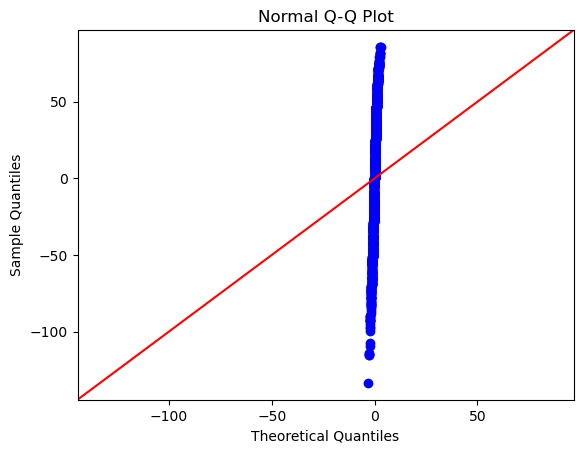

In [ ]:
# plot the QQ plot
residual = y_pred - y
plot_qq(residual)
plt.savefig('QQ.png')

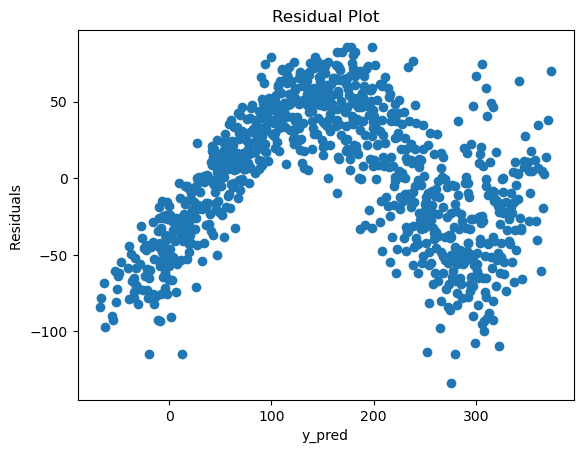

In [ ]:
# plot the residuals scatter plot
residual = y_pred - y
plot_residuals(y_pred,residual)
plt.savefig('rp.png')

## Attempted Transformation of days_after_open

As the final model was found to violate some of the assumptions we had to try to perform variable transformations to fix these violations.

This model still violated the assumptions and thus was not reported in the final report.

In [ ]:
# Just copied the code from above for the sake of convience and to avoid any risk of human error - placed at bottom to avoid too many dependency issues
fea_name=['days_after_open','raining_Yes','dist_to_cafe','hours_after_open']
fea_name.remove('dist_to_cafe')
full_df['days_after_open'] = full_df['days_after_open']**2
X=full_df[fea_name]

y=full_df['hourly_sales']
linear_reg_final = LinearRegression(fit_intercept=True)

# to make the intercept unequals to zero
linear_reg_final.fit(X, y)
y_pred = linear_reg_final.predict(X)
# y_pred_1 = linear_reg_rain.predict(X)
y_pred

array([ 5.86726466e+01,  5.23184621e+01,  7.08993495e+00,  3.96100930e+01,
       -5.61843410e+00,  2.69017240e+01,  5.86887976e+01,  5.23346130e+01,
        4.59804285e+01,  3.96262440e+01,  3.32720595e+01,  2.69178749e+01,
        5.87372504e+01,  5.23830659e+01,  4.60288814e+01,  8.00354239e-01,
       -5.55383028e+00,  2.69663278e+01,  1.99436626e+01,  5.24638207e+01,
        4.61096361e+01,  3.97554516e+01,  3.34012671e+01, -1.18272600e+01,
        2.00567192e+01,  5.25768773e+01,  4.62226928e+01,  9.94165677e-01,
        3.35143238e+01, -1.17142034e+01,  5.90764204e+01,  1.38478933e+01,
        4.63680514e+01,  1.13952426e+00,  3.36596824e+01,  2.73054978e+01,
        5.92540809e+01,  5.28998964e+01,  4.65457119e+01,  4.01915274e+01,
       -5.03699978e+00,  2.74831583e+01,  5.94640433e+01,  5.31098588e+01,
        4.67556743e+01,  4.04014898e+01, -4.82703739e+00,  2.76931207e+01,
        5.97063076e+01,  1.44777805e+01,  4.69979386e+01,  4.06437540e+01,
        3.42895695e+01,  

In [ ]:
# Calculating the transformed MSE
final_transform_mse=mse(y_pred,y)
print(final_transform_mse)

1105.0216398474129


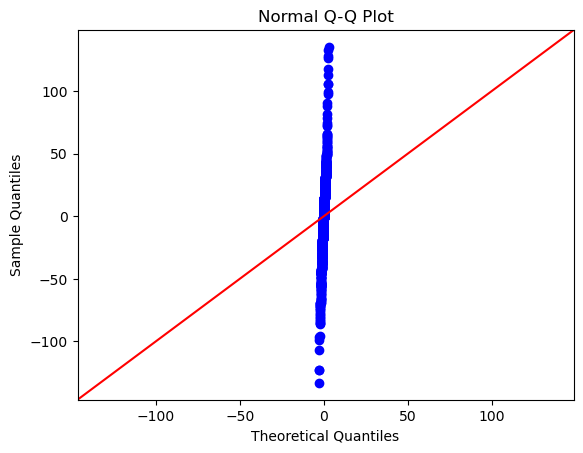

In [ ]:
# plot the QQ plot
residual = y_pred - y
plot_qq(residual)

plt.savefig('QQ.png')

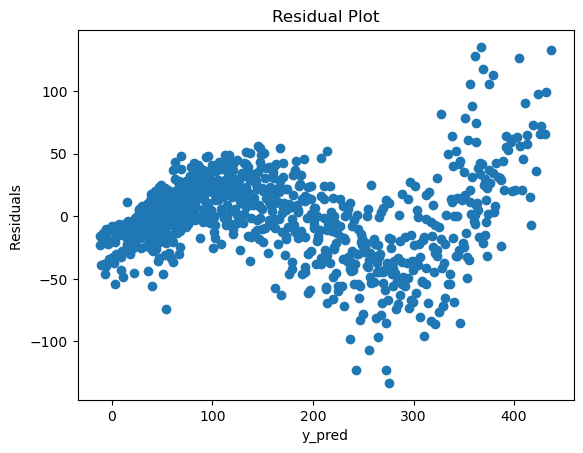

In [ ]:
# plot the residuals scatter plot
plot_residuals(y_pred,residual)
plt.savefig('rp.png')